In [ ]:
# Fixing a single SAE feature, which MLP neurons (in earlier and later layers) show high pearson correlation with the SAE feature?

In [6]:
import os

import torch as t
import numpy as np
import einops
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

from circuits.dictionary_learning.buffer import NNsightActivationBuffer
from circuits.dictionary_learning.dictionary import AutoEncoder, AutoEncoderNew, GatedAutoEncoder
import circuits.othello_utils as othello_utils
from circuits.utils import (
    othello_hf_dataset_to_generator,
    get_model,
    get_submodule,
)

repo_dir = '/home/can/chess-gpt-circuits'
device = 'cuda:0'

In [7]:
# download data from huggingface if needed
if not os.path.exists(f'{repo_dir}/autoencoders/group-2024-05-17_othello'):
    hf_hub_download(repo_id='adamkarvonen/othello_saes', filename='group-2024-05-17_othello.zip', local_dir=f'{repo_dir}/autoencoders')
    # unzip the data
    os.system(f'unzip {repo_dir}/autoencoders/group-2024-05-17_othello.zip -d autoencoders')

In [8]:
# load SAE
ae_type = 'standard_new'
trainer_id = 0

ae_path = f'{repo_dir}/autoencoders/group-2024-05-17_othello/group-2024-05-17_othello-{ae_type}/trainer{trainer_id}'
if ae_type == 'standard':
    ae = AutoEncoder.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
elif ae_type == 'gated':
    ae = GatedAutoEncoder.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
elif ae_type == 'standard_new':
    ae = AutoEncoderNew.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
else:
    raise ValueError('Invalid ae_type')

In [9]:
# load model and data

layer = 5
context_length = 59
activation_dim = 512  # output dimension of the layer
model_name = "Baidicoot/Othello-GPT-Transformer-Lens"
dataset_name = "taufeeque/othellogpt"

game_batch_size = 100

model = get_model(model_name, device)

submodule = get_submodule(model_name, layer, model)
model.blocks[layer].hook_resid_post

mlp_post_submodules = [model.blocks[l].mlp.hook_post for l in range(model.cfg.n_layers)]


data = othello_hf_dataset_to_generator(
    dataset_name, context_length=context_length, split="train", streaming=True
)
data = othello_hf_dataset_to_generator(
    dataset_name, context_length=context_length, split="train", streaming=True
)
game_batch = [next(data) for _ in range(game_batch_size)]
game_batch = t.tensor(game_batch, device=device)
print(f'game_batch: {len(game_batch)}')

Loaded pretrained model Baidicoot/Othello-GPT-Transformer-Lens into HookedTransformer
Moving model to device:  cuda:0


Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

game_batch: 100


## Choosing single SAE feature

From feature viz notebook: Feature #21 of f'{repo_dir}/autoencoders/group-2024-05-17_othello/group-2024-05-17_othello-{standard_new}/trainer{0}' looks like it is representing a piece on H1 or G1

<img src="./feat21.png" alt="Image description" width="800"/>

In [10]:
feat_idx = 21

In [11]:
# Caching activations with nnsight
mlp_acts = {}

with t.no_grad(), model.trace(game_batch, scan=False, validate=False):
    x = submodule.output
    feature_acts = ae.encode(x).save()
    for l in range(model.cfg.n_layers):
        mlp_acts[l] = mlp_post_submodules[l].output.save()

feature_acts = einops.rearrange(feature_acts, "B S F -> F (B S)")
feature_acts = feature_acts[feat_idx]

for l in mlp_acts:
    mlp_acts[l] = einops.rearrange(mlp_acts[l], "B S F -> F (B S)")

In [18]:
# Pearson correlation calculation function
def pearson_corr(x, y):
    mean_x = x.mean(dim=-1, keepdim=True)
    mean_y = y.mean(dim=-1, keepdim=True)
    xm = x - mean_x
    ym = y - mean_y
    r_num = t.sum(xm * ym, dim=-1)
    r_den = t.sqrt(t.sum(xm * xm, dim=-1) * t.sum(ym * ym, dim=-1))
    r = r_num / r_den
    return r

# Calculate Pearson correlation
pearson_correlations = {}

for l in mlp_acts:
    mlp_acts_layer = mlp_acts[l]
    correlations = t.zeros(mlp_acts_layer.shape[0])
    for i in range(mlp_acts_layer.shape[0]):
        mlp_feature = mlp_acts_layer[i]
        corr = pearson_corr(feature_acts, mlp_feature)
        correlations[i] = corr
    pearson_correlations[l] = correlations

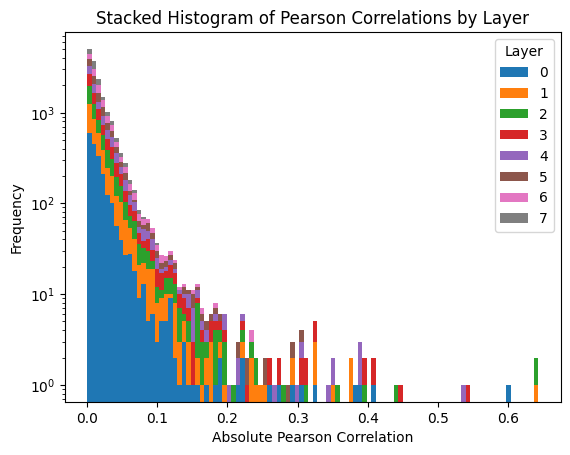

In [24]:
# Prepare data
layers = list(pearson_correlations.keys())
data = [pearson_correlations[l].abs() for l in layers]

# Create stacked histogram
plt.hist(data, bins=100, histtype='bar', stacked=True, label=layers)

# Add legend and log scale for y-axis
plt.legend(title='Layer')
plt.yscale('log')

# Display plot
plt.xlabel('Absolute Pearson Correlation')
plt.ylabel('Frequency')
plt.title('Stacked Histogram of Pearson Correlations by Layer')
plt.show()

In [27]:
# import numpy as np
# import pandas as pd
# import plotly.express as px

# # Mock data for demonstration
# np.random.seed(42)
# pearson_correlations = {
#     'Layer 1': np.random.rand(100),
#     'Layer 2': np.random.rand(100),
#     'Layer 3': np.random.rand(100)
# }

# # Prepare data for Plotly
# layers = list(pearson_correlations.keys())
# data = [np.abs(pearson_correlations[l]) for l in layers]

# # Create a DataFrame for easier handling in Plotly
# df_list = []
# for layer in layers:
#     layer_data = pd.DataFrame({
#         'Absolute Pearson Correlation': np.abs(pearson_correlations[layer]),
#         'Layer': layer,
#         'neuron_Index': range(len(pearson_correlations[layer]))
#     })
#     df_list.append(layer_data)

# df = pd.concat(df_list)

# # Create the stacked histogram
# fig = px.histogram(df, x='Absolute Pearson Correlation', color='Layer', barmode='stack',
#                    hover_data=['neuron_Index', 'Layer'])

# # Update layout for log scale on y-axis
# fig.update_layout(
#     yaxis=dict(type='log'),
#     title='Stacked Histogram of Pearson Correlations by Layer',
#     xaxis_title='Absolute Pearson Correlation',
#     yaxis_title='Frequency'
# )

# fig.show()


/home/can/.conda/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [28]:
# import numpy as np
# import pandas as pd
# import plotly.express as px

# # Mock data for demonstration
# np.random.seed(42)
# pearson_correlations = {
#     'Layer 1': np.random.rand(100),
#     'Layer 2': np.random.rand(100),
#     'Layer 3': np.random.rand(100)
# }

# # Prepare data for Plotly
# layers = list(pearson_correlations.keys())
# data = [np.abs(pearson_correlations[l]) for l in layers]

# # Create a DataFrame for easier handling in Plotly
# df_list = []
# for layer in layers:
#     layer_data = pd.DataFrame({
#         'Absolute Pearson Correlation': np.abs(pearson_correlations[layer]),
#         'Layer': layer,
#         'Neuron Index': range(len(pearson_correlations[layer]))
#     })
#     df_list.append(layer_data)

# df = pd.concat(df_list)

# # Create the stacked histogram
# fig = px.histogram(df, x='Absolute Pearson Correlation', color='Layer', barmode='stack',
#                    hover_data={'Neuron Index': True, 'Layer': True})

# # Update layout for log scale on y-axis and add hover template
# fig.update_traces(hovertemplate='<br>'.join([
#     'Absolute Pearson Correlation: %{x}',
#     'Count: %{y}',
#     'Neuron Index: %{customdata[0]}',
#     'Layer: %{customdata[1]}'
# ]))

# fig.update_layout(
#     yaxis=dict(type='log'),
#     title='Stacked Histogram of Pearson Correlations by Layer',
#     xaxis_title='Absolute Pearson Correlation',
#     yaxis_title='Frequency'
# )

# fig.show()


/home/can/.conda/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

